In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import util
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [2]:
artist_df = pd.read_pickle('data/artist_04092018.pkl')
exhibition_df = pd.read_pickle('data/exhibition_04092018.pkl')

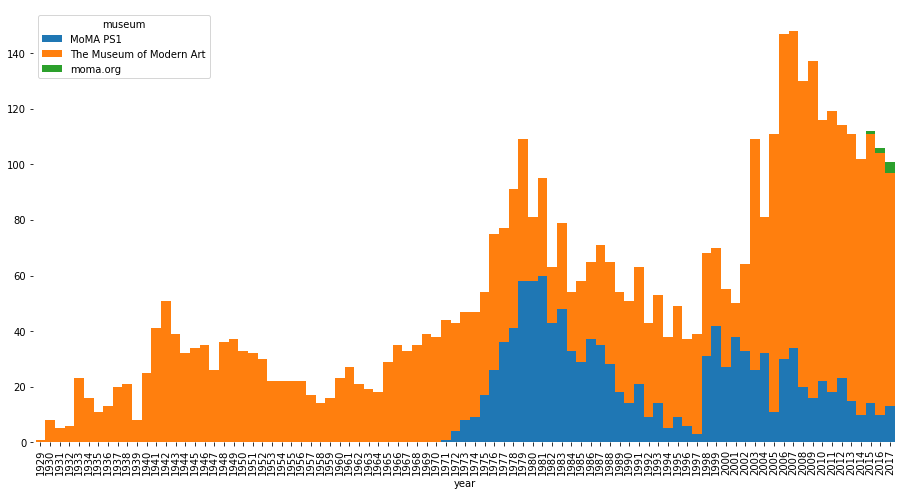

In [3]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.3)

fil = (exhibition_df['year']!=-1) & \
      (exhibition_df['year'] < 2018) & \
      ((exhibition_df['museum'] == "The Museum of Modern\xa0Art") | \
       (exhibition_df['museum'] == "MoMA\xa0PS1") | \
       (exhibition_df['museum'] == "moma.org"))
    
exhibition_df[fil].groupby(['year', 'museum'])['year', 'museum'] \
    .size() \
    .reset_index(name='counts') \
    .sort_values(by='year') \
    .pivot(index='year', columns='museum', values='counts') \
    .fillna(0) \
    .reset_index() \
    .plot.bar(x='year', stacked=True, ax=ax1, width=1, linewidth=0)

In [4]:
def artist_by_exhibit_year(year, museum='moma', exhibition='all'):
    """
    Gets artists by year of exhibition.
    
    Parameters:
    - year: (int) the year to filter on
    - musuem: (str) the musuem to filter on ['moma', 'ps1', 'moma.org']
    - exhibition: (str) solo exhibitions or all exhibitions ['all', 'solo']
    """
    if museum == 'moma':
        museum = "The Museum of Modern\xa0Art"
    if museum == 'ps1': 
        museum = "MoMA\xa0PS1"
    if museum == 'moma.org':
        museum = "moma.org"
        
    e_df = exhibition_df
    if exhibition == 'solo':
        e_df['artist_count'] = e_df['artists'] \
            .apply(lambda x: len(x.split(', ')) if len(x.split(',')) >= 1 else 0)
        e_df = e_df[e_df['artist_count']==1]
    
    # get artists from a specific year of exhibitions
    fil = (e_df['artists'] != '') & (e_df['year'] == year) & (e_df['museum'] == museum)
    artist_filter = ', '.join(list(e_df[fil]["artists"])).split(', ')
    artist_filter_df = pd.DataFrame(artist_filter, columns=["artist_name"])
    
    # join the list of artists with artists_df to get race/gender/nationality data
    artist_filter_merged_df = artist_filter_df.merge(artist_df[["artist_name", "race", "gender", "nationality"]], on=["artist_name"])

    return artist_filter_merged_df

In [5]:
def plot_time_series(fil, start, end, museum='moma', exhibition='all', style="--", omit=[], top=10):
    """
    Plots time series of data by a specified 'filter'
    
    Parameters:
    - fil: (str) ["race", "gender", or "nationality"]
    - start: (int) start year
    - end: (int) end year
    - museum: (str) ['moma' (default), 'ps1', 'moma.org']
    - exhibition: (str) all vs solo-shows only ['all' (default), 'solo']
    - style: (str) "--" line graph, "=" stacked bar graph
    - omit: [str] values to omit (such as "white")
    """
    title = "Number of Artists who exhibited in %s by %s between %i and %i %s" % \
        (museum, fil, start, end, "[solo exhibits only]" if exhibition=='solo' else '')
    
    # plot settings
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.3)
    
    time_series = pd.DataFrame([], columns=["year"])
    
    # collect artist through each year (end - start)
    for i in range(start, end):
        t = artist_by_exhibit_year(i, museum, exhibition) #.to_dict()
        t = t[(t['race'] != '') & (t['gender'] != '')][fil].value_counts(dropna=True).to_dict()
        t['year'] = str(i)
        time_series = time_series.append(t, ignore_index=True)

    time_series = time_series.set_index("year")
    time_series = time_series.fillna(value=0)
    
    # omit columns
    if len(omit) > 0:
        time_series = time_series.drop(omit, axis=1)
        
    # get top 10 at max
    column_filter = time_series.sum().sort_values(ascending=False).index[:top]
    time_series = time_series[column_filter]

    # plot quantity
    if style == "--":
        time_series.plot(ax=ax1, title=title, linewidth=0)
    if style == "=":
        time_series.plot.bar(ax=ax1, title=title, stacked=True, width=1, linewidth=0)
    ax1.set_ylim(bottom=0)
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax1.set_xlabel('')
    ax1.set_ylabel('# of artists who exhibited')

    # plot pct
    feature_pct_df = time_series.divide(time_series.sum(axis=1) +.000000001, axis=0)
    if style == "--":
        feature_pct_df.plot(ax=ax2, title=title + " [PCT]", edgecolor = "none")
    if style == "=":
        feature_pct_df.plot.bar(ax=ax2, title=title + " [PCT]", stacked=True, width=1, edgecolor = "none")
    ax2.set_ylim(top=1, bottom=0)    
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax2.set_xlabel('')
    ax2.set_ylabel('% of artists who exhibited')

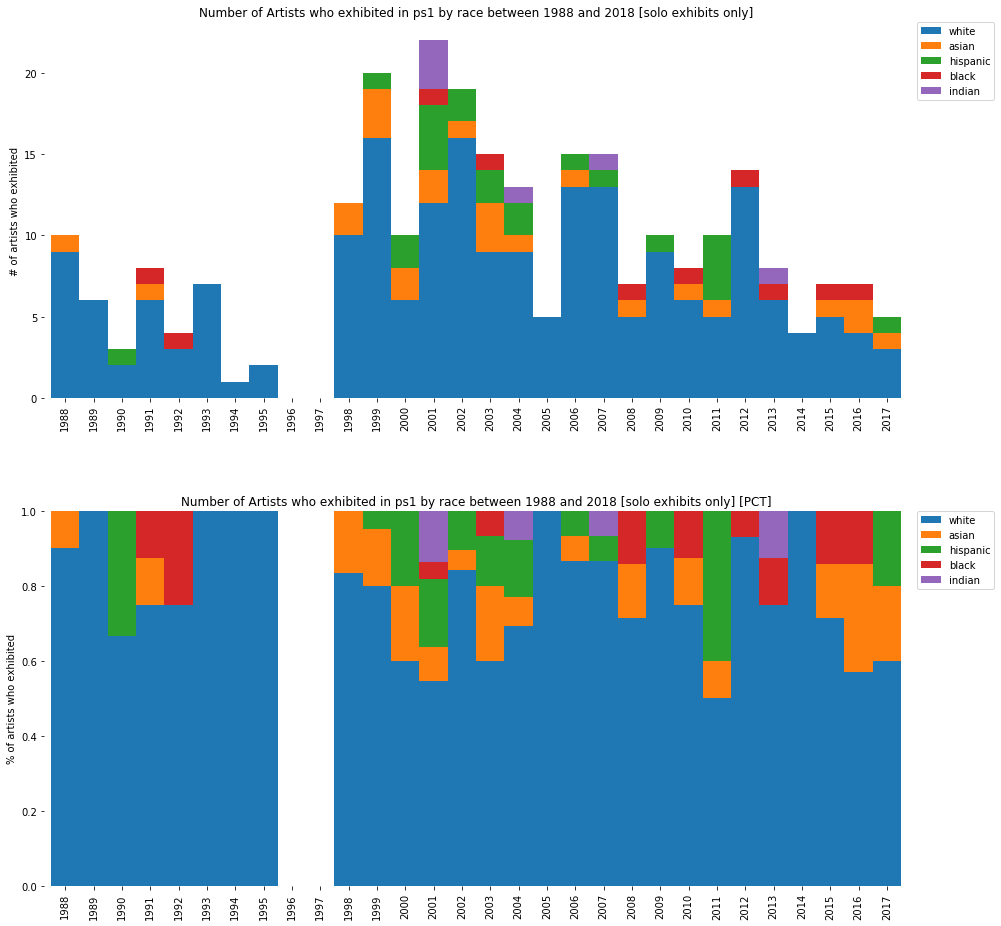

In [6]:
plot_time_series(fil="race", \
                 start=1988, \
                 end=2018, \
                 museum='ps1', \
                 exhibition='solo', \
                 style="=", 
                 omit=[])

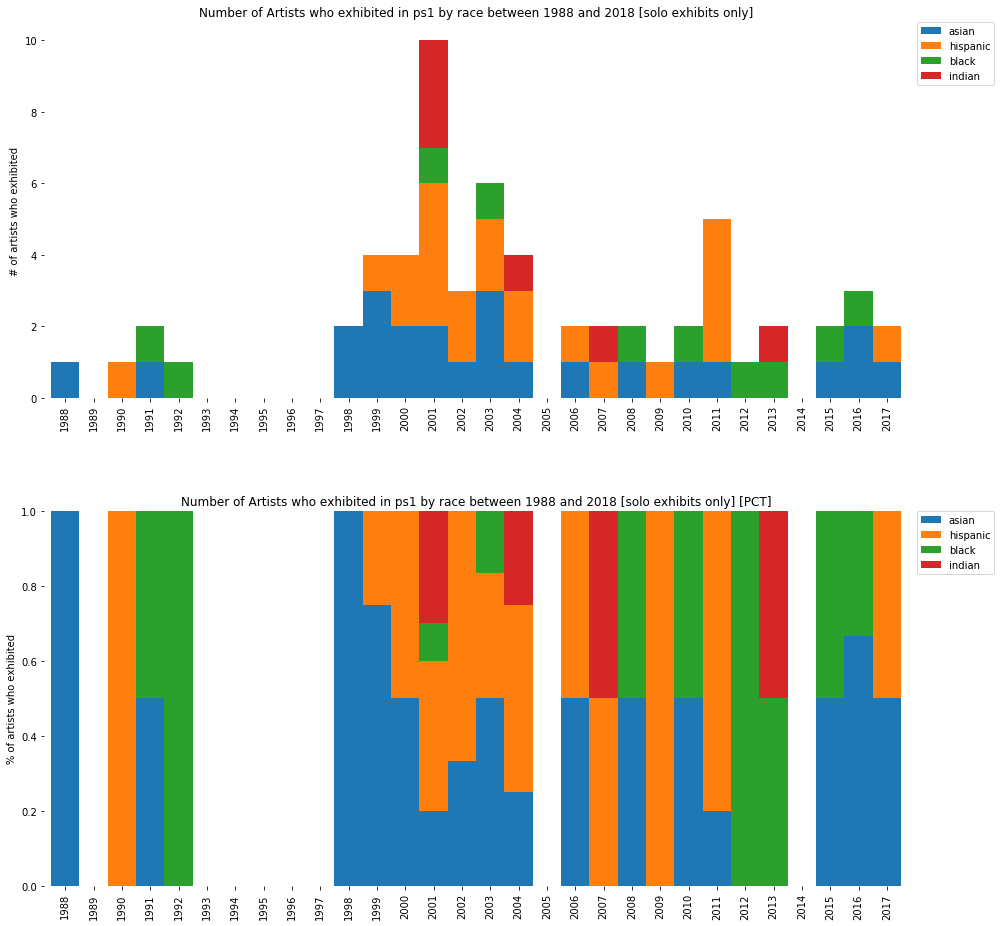

In [9]:
plot_time_series(fil="race", \
                 start=1988, \
                 end=2018, \
                 museum='ps1', \
                 exhibition='solo', \
                 style="=", \
                 omit=["white"])

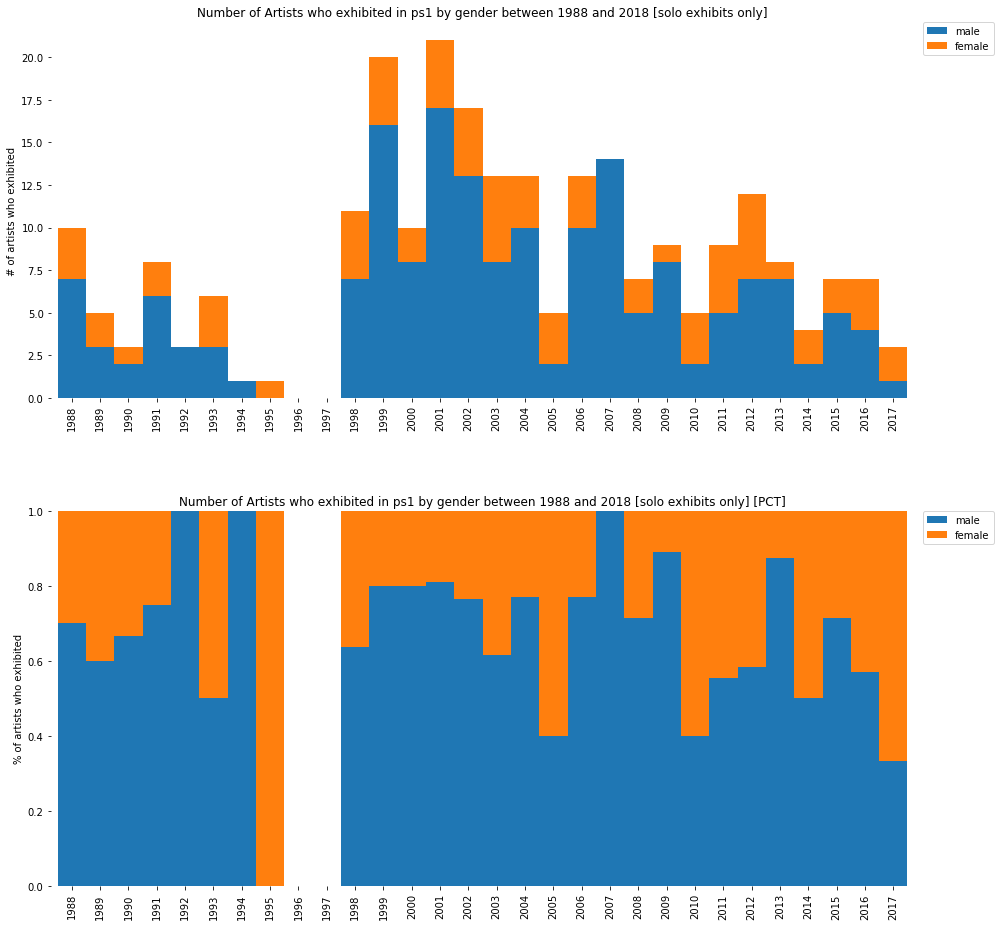

In [11]:
plot_time_series(fil="gender", \
                 start=1988, \
                 end=2018, \
                 museum='ps1', \
                 exhibition='solo', \
                 style="=", \
                 omit=["None"])

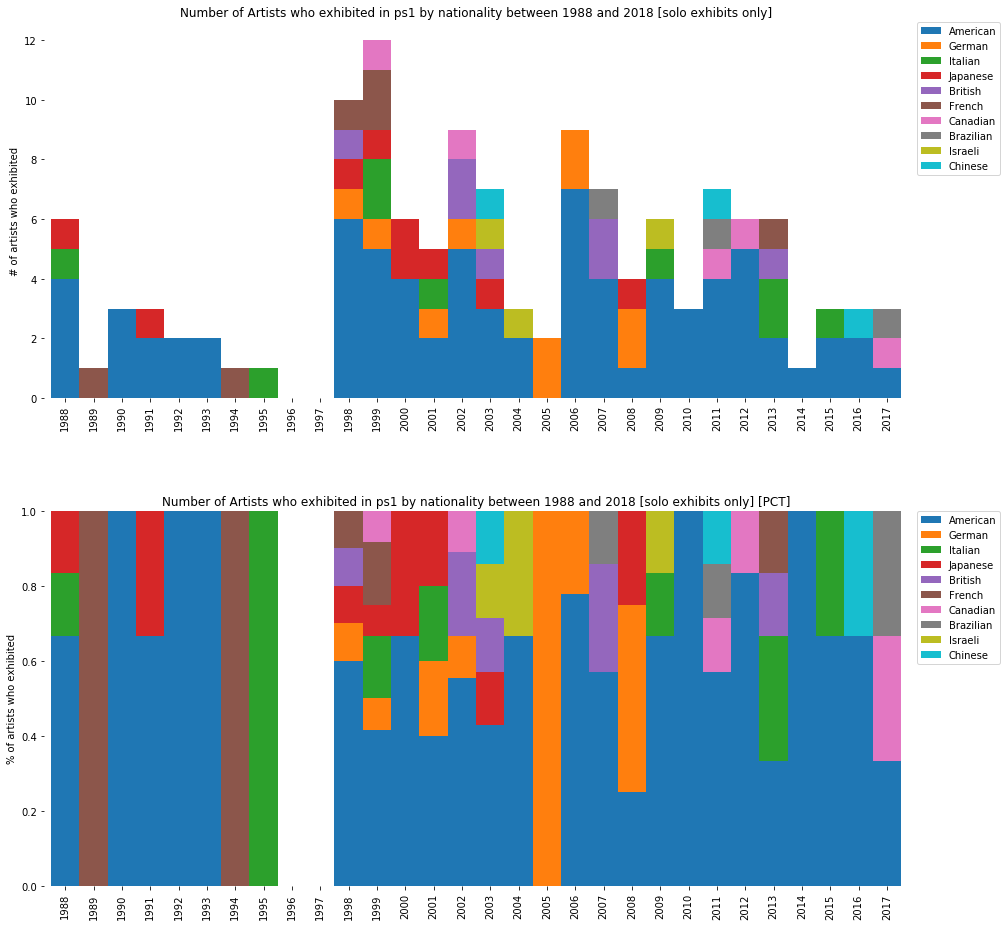

In [10]:
plot_time_series(fil="nationality", \
                 start=1988, \
                 end=2018, \
                 museum='ps1', \
                 exhibition='solo', \
                 style="=", \
                 omit=[""])

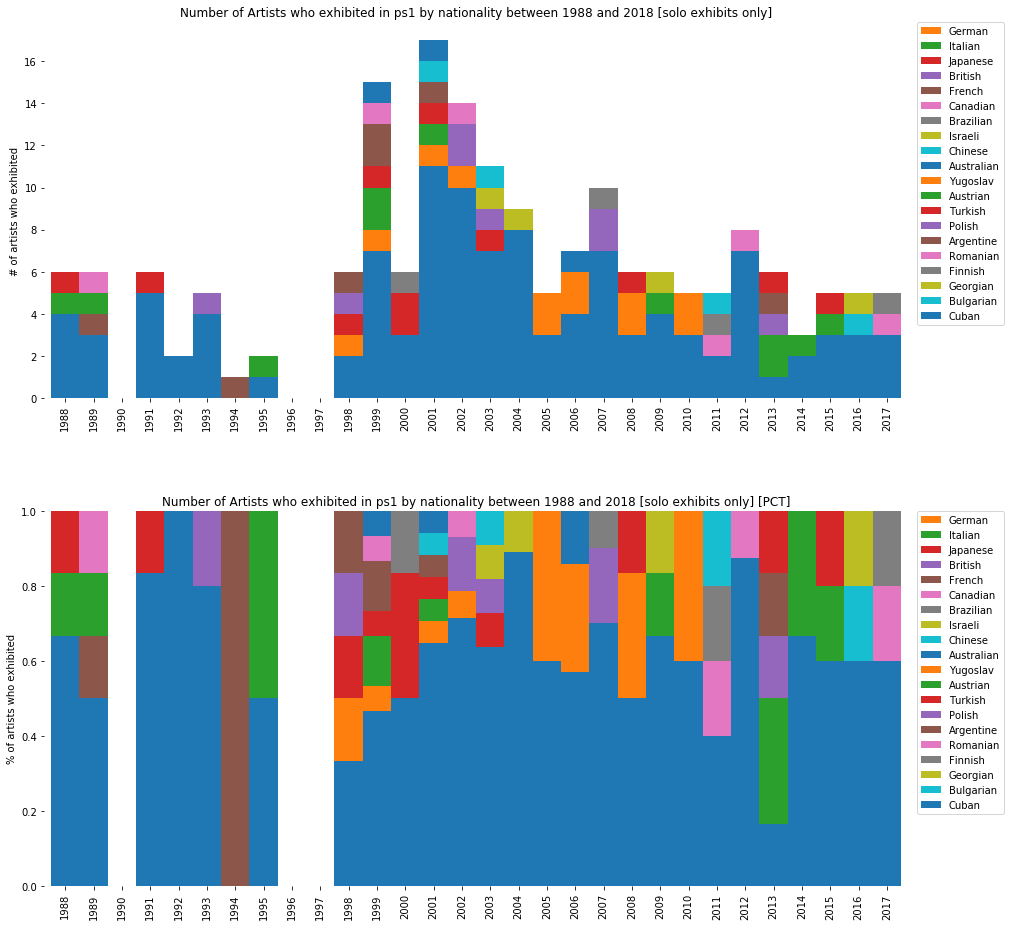

In [12]:
plot_time_series(fil="nationality", \
                 start=1988, \
                 end=2018, \
                 museum='ps1', \
                 exhibition='solo', \
                 style="=", \
                 omit=["American"], \
                 top=21)

In [13]:
def plot_race_gender_across_years(years=[1957, 1977, 1997, 2017]):
    """
    This function will print out 2 graphs to show the race and gender distribution of artists who have
    exhibited at the MoMA, across the 4 years that
    
    Parameters:
    - years: [int], where max len == 4
    """
    df_array = []
    for year in years:
        df_array.append(artist_by_exhibit_year(year))

    fig = plt.figure(figsize=(12, 15))
    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.5)
    
    axes = []
    for i in range(1, 2 * len(years) + 1):
        a = fig.add_subplot(4, 2, i)
        axes.append(a)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['left'].set_visible(False)

    for i, year in enumerate(years):
        util.plot_distribution(dist_df=df_array[i][df_array[i]['race']!='']['race'].value_counts(dropna=True),
            title="Race Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[2*i])

        util.plot_distribution(dist_df=df_array[i][df_array[i]['gender']!='None']['gender'].value_counts(dropna=True),
            title="Gender Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[(2*i)+1])
        

def plot_nationality_across_years(years=[1957, 1977, 1997, 2017]):
    """
    This function will print out 2 graphs to show the race and gender distribution of artists who have
    exhibited at the MoMA, across the 4 years that
    
    Parameters:
    - years: [int], where max len == 4
    """
    df_array = []
    for year in years:
        df_array.append(artist_by_exhibit_year(year))

    fig = plt.figure(figsize=(12, 15))
    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.5)
    
    axes = []
    for i in range(1, len(years) + 1):
        a = fig.add_subplot(4, 1, i)
        axes.append(a)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['left'].set_visible(False)

    for i, year in enumerate(years):
        util.plot_distribution(dist_df=df_array[i][df_array[i]['nationality']!='']['nationality'].value_counts(dropna=True)[:10],
            title="Nationality Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[i], show_pct=False)

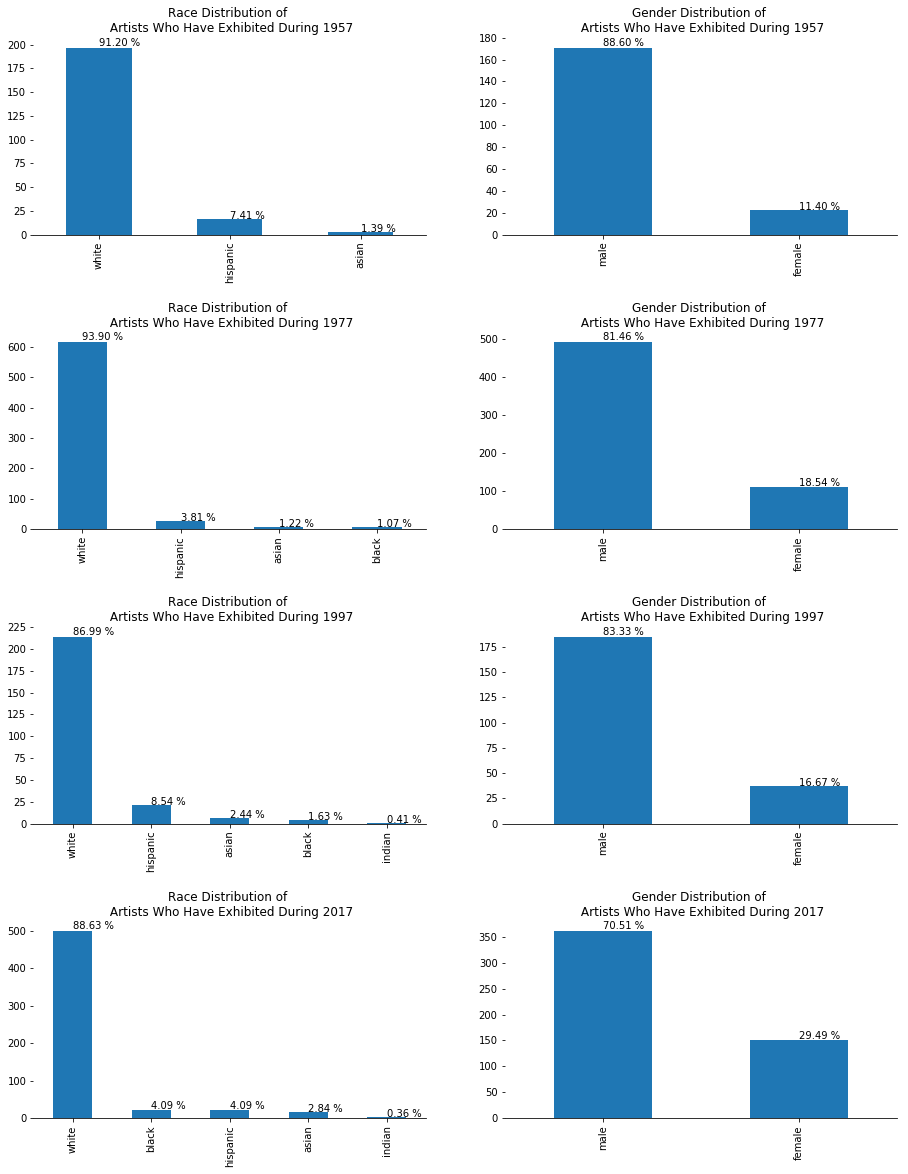

In [14]:
plot_race_gender_across_years(years=[1957, 1977, 1997, 2017])

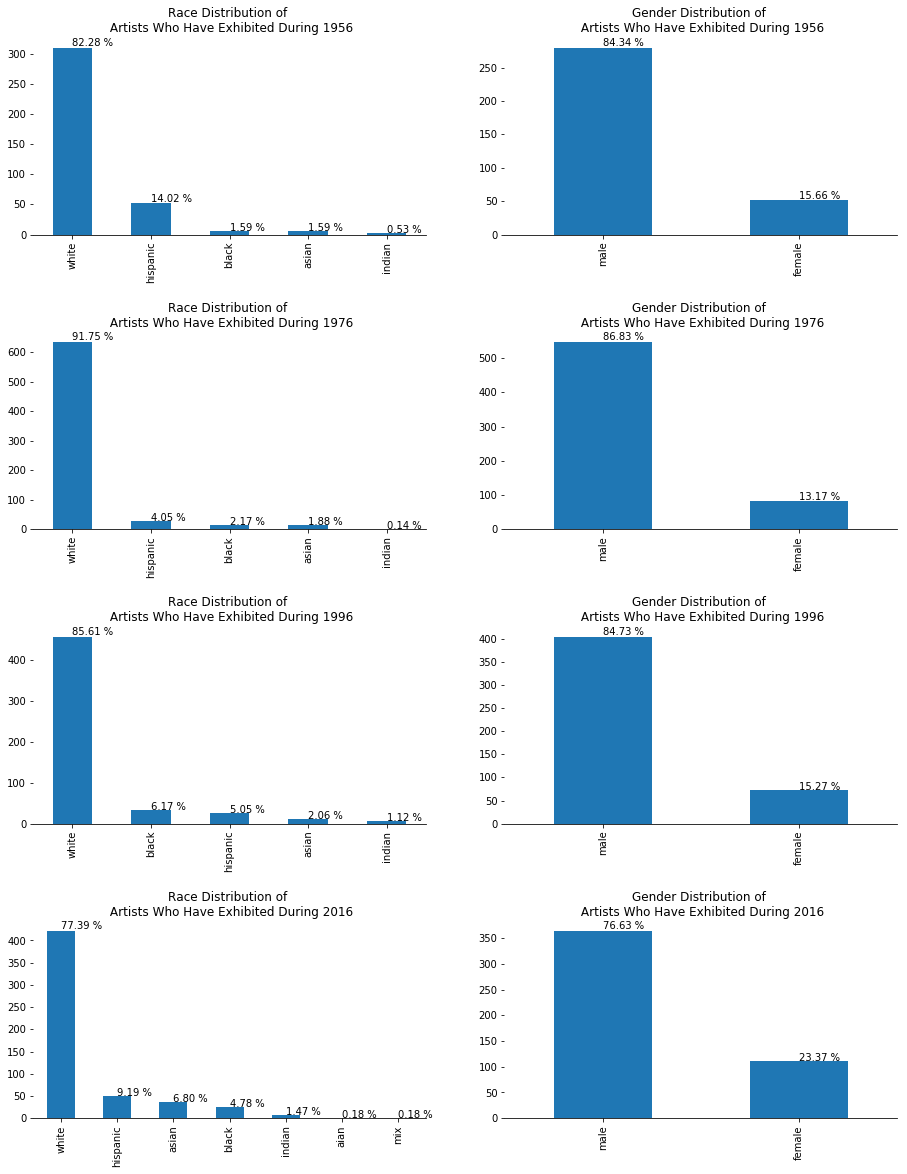

In [15]:
plot_race_gender_across_years(years=[1956, 1976, 1996, 2016])

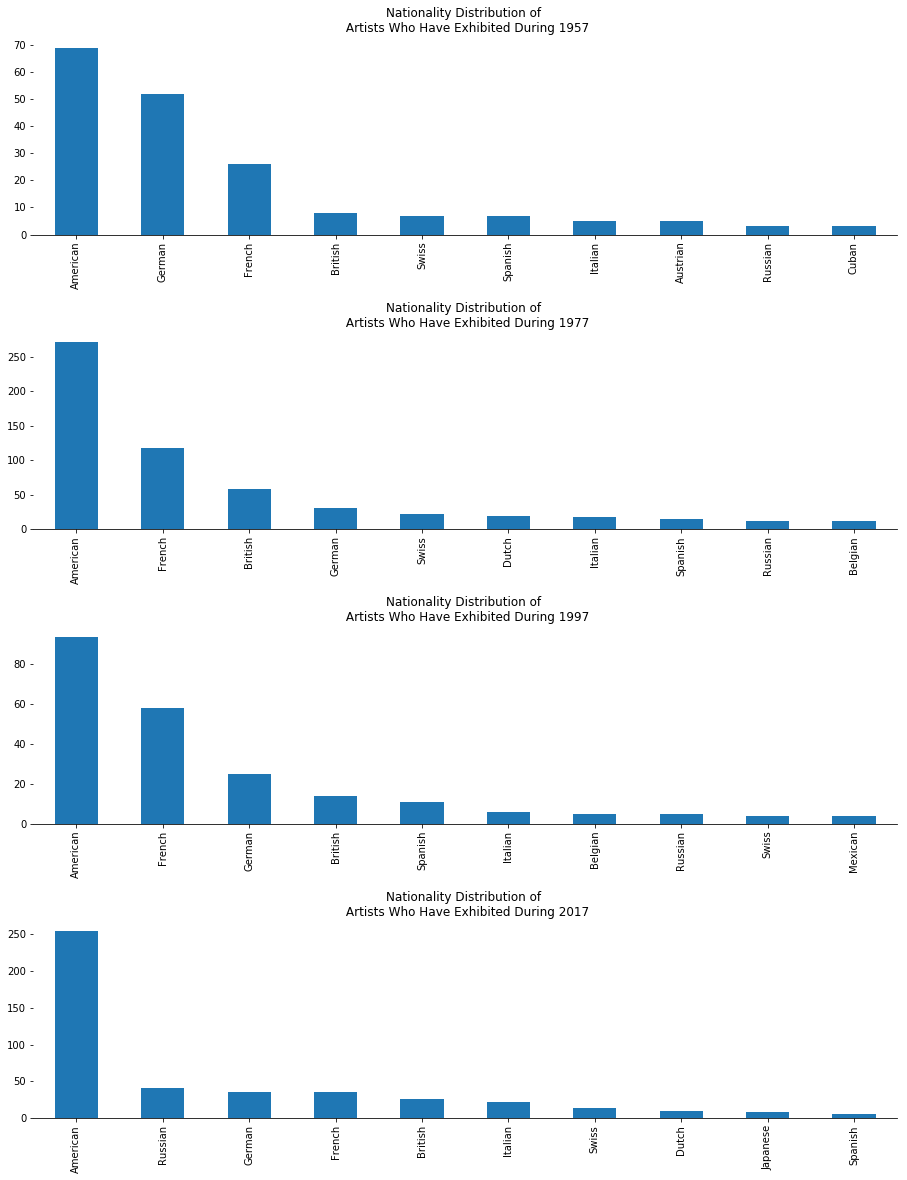

In [16]:
plot_nationality_across_years()

In [17]:
def get_top_exhibited_artists(start, end, top=50, museum='moma', exhibition='all'):
    """
    Get the top exhibited artists by some specified range of years
    
    Parameters:
    - start: (int) start year
    - end: (int) end year
    - top: (int) the top x number of artists to select
    """
    time_series = pd.DataFrame([])

    for i in range(start, end):
        t = artist_by_exhibit_year(i, museum=museum, exhibition=exhibition)
        time_series = time_series.append(t, ignore_index=True)

    ret = time_series.groupby(time_series.columns.tolist(), as_index=False)\
        .size().reset_index().rename(columns={0: 'count'})\
        .sort_values(by='count', ascending=False)\
        .reset_index().drop("index", axis=1).iloc[0:top]
    
    return ret

In [18]:
get_top_exhibited_artists(2007, 2017, top=45).head() # ['race'].value_counts()

# in the past 10 years, there have been 181 artists whose work has been exhibited more than 5 times
# of those 181, only 15 (8%) are PoC (9 hispanics, 2 blacks, and 4 asians)

# in the past 10 years, there have been 45 artists whose work has been exhibited more than 10 times
# of those 45, only 5 (11%) are PoC (2 hispanics, 1 blacks, and 2 asians)

,artist_name,race,gender,nationality,count
0,Pablo Picasso,hispanic,male,Spanish,19
1,Bruce Nauman,white,male,American,19
2,Robert Rauschenberg,white,male,American,19
3,Man Ray (Emmanuel Radnitzky),white,male,American,18
4,John Baldessari,white,male,American,16


In [ ]:
# exhibition_df['artist_count'] = exhibition_df['artists'].apply(lambda x: len(x.split(', ')) if len(x.split(',')) >= 1 else 0)

In [120]:
# exhibition_df[(exhibition_df['artist_count']==1) & (exhibition_df['year'] == 1944) & (exhibition_df['artists'] != "")]

,artists,date_full_text,exhibition_title,museum,press_release,year,artist_count
2250,W. Eugene Smith,"May 10–June 30, 1944",Pacific Report: Photos by Eugene Smith,The Museum of Modern Art,,1944,1
2264,Ansel Adams,"November 10–December 24, 1944",Manzanar: Photographs by Ansel Adams of Loyal ...,The Museum of Modern Art,,1944,1
2800,Alexander Calder,"September 29, 1943–January 16, 1944",Alexander Calder,The Museum of Modern Art,,1944,1
3078,Norman Bel Geddes,"January 26–March 5, 1944",Norman Bel Geddes' War Maneuver Models,The Museum of Modern Art,,1944,1
3084,Jacob Lawrence,"October 10–November 5, 1944",Paintings by Jacob Lawrence,The Museum of Modern Art,,1944,1
3320,Pablo Picasso,"June 26–September 10, 1944",Art in Progress: 15th Anniversary Exhibitions:...,The Museum of Modern Art,,1944,1


relevant links:
- https://news.artnet.com/exhibitions/bodys-isek-kingelez-moma-1104215

In [24]:
get_top_exhibited_artists(2017, 2018, top=None).shape[0] + \
get_top_exhibited_artists(1997, 1998, top=None).shape[0] + \
get_top_exhibited_artists(1977, 1978, top=None).shape[0] + \
get_top_exhibited_artists(1957, 1958, top=None).shape[0]

1434

In [131]:
    white_male_list = [\
        "sol lewitt", "ellsworth kelly", "edward ruscha", "john marin", "philip guston", "jonathan borofsky", \
        "william brice", "robert morris", "ben shahn", "e. mcknight kauffer", "robert andrew parker", "jan müller", \
        "jules pascin", "william t. wiley", "mark rothko", "varujan boghosian", "raoul hague", "joseph glasco", \
        "robert wilson", "garry winogrand", "albert alcalay", "gandy brodie", "frank lloyd wright", "raimund abraham", \
        "morris graves", "christopher wool", "merce cunningham", "louis michel eilshemius", "robert brownjohn", \
        "woody vasulka", "sam francis","robert indiana", "william wegman", "gordon matta-clark", "mel bochner", \
        "willem de kooning", "milton avery", "felix gonzalez-torres", "douglas huebler", "r. buckminster fuller", \
        "tom wesselmann", "terry allen", "william bailey", "robert mapplethorpe", "richard foreman", "rafael ferrer", \
        "pirkle jones", "philippe halsman", "peter campus", "charles atlas", "douglas davis", "caldecot chubb", \
        "ben schonzeit", "jared bark", "jerry uelsmann", "abraham walkowitz", "peter young", "roger brown", \
        "tim rollins", "leon polk smith", "david park", "charles fahlen", "barry le va", "ian (hugh guiler) hugo", \
        "king vidor", "walter lang", "walter burley griffin", "val telberg", "paul taylor", "r. crumb", "remy charlip", \
        "robert breer", "bruce graham", "busby berkeley", "charles gwathmey", "charles j. brabin", "david levinthal", \
        "albert herbert", "allan mccollum", "eugene masselink", "george cukor", "willy mucha", "théo van rysselberghe", \
        "théophile-alexandre steinlen", "rené magritte", "hans namuth", "tom wesselmann", "mark di suvero", \
        "robert watts", "abraham walkowitz", "russell lee", "robert capa", "barry le va", "jerry uelsmann", \
        "george nelson", "joel meyerowitz", "william lescaze", "francis bruguière", "philip evergood", "jim shaw", \
        "george him", "günther förg", "rené robert bouché", "esteban vicente", "peter grippe", "mark grotjahn", \
        "john hejduk", "cornell capa", "robert gwathmey", "robert heinecken", "ed emshwiller", "donald sultan", \
        "gregory amenoff", "nathan george horwitt", "maurice sterne", "jean charlot", "timothy o'sullivan", \
        "alton pickens", "louis faurer", "richard neutra", "louis lozowick", "alfred leslie", "morris louis", \
        "kim jones", "carleton e. watkins", "william vandivert", "jules olitski", "louis schanker", \
        "walter dorwin teague", "edward kienholz", "nathan lyons", "walter robinson", "larry poons", "john steuart curry", \
        "alphonse mucha", "robert laurent", "bill beckley", "alfred eisenstaedt", "harwell hamilton harris", \
        "thomas wilfred", "ron davis", "geoffrey hendricks", "alain kirili", "john szarkowski", \
        "henry hobson richardson"]
    len(white_male_list)

145

In [29]:
exhibition_df.head()

,artists,date_full_text,exhibition_title,museum,press_release,year,artist_count
0,"Peter Cook, Cristiano Toraldo di Francia, Gian...","November 15, 2006–March 26, 2007",OMA in Beijing: China Central Television Headq...,The Museum of Modern Art,<p>This exhibition presents one of the most in...,2007,17
1,Brice Marden,"October 29, 2006–January 15, 2007",Brice Marden: A Retrospective of Paintings and...,The Museum of Modern Art,<p>This retrospective of the artist Brice Mard...,2007,1
2,"Jonathan Monk, Barbara Probst, Jules Spinatsch","September 21, 2006–January 8, 2007","New Photography 2006: Jonathan Monk, Barbara P...",The Museum of Modern Art,<p>New Photography is the annual fall showcase...,2007,3
3,"Arman, John Armleder, Atelier Populaire, Fiona...","October 15, 2006–January 1, 2007","Eye on Europe: Prints, Books &amp; Multiples/1...",The Museum of Modern Art,<p>Taking the explosion of the screenprint in ...,2007,101
4,"Vito Acconci, William Anastasi, Janine Antoni,...","August 30, 2006–April 9, 2007",Out of Time: A Contemporary View,The Museum of Modern Art,"<p>Repeat, fast-forward, rewind, pause, recycl...",2007,36
